In [ ]:
#Functions for CSV Processing
from bdb import effective
import os
from pathlib import Path
from site import check_enableusersite
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import math
from matplotlib.lines import Line2D
from collections import Counter
from reproject import reproject_exact, reproject_adaptive, reproject_interp
# Force output display
from IPython.display import display
import sys

sys.stdout.flush()  # Force flush

# Also check if you have this at the top of your notebook
# %config InteractiveShell.ast_node_interactivity='all'

#Modify for IC5146 and other scales
scale_colors = {
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}



def getInfo(label, csv_path):

    """
    Read the csv file for information about an image and return the distance, res, pixscale, and powers of 2

    Parameter
    - label (str): The label for the celestial object that the image is of, commonly a galaxy name
    - csv_path (str): The path to the csv file containing relevant information

    Returns:
    - distance (float): distance to the image
    - res (float): angular resolution
    - pixscale (float): pixel resolution
    - min_power (float): minimum power of 2 for scale decomposition
    - max_power (float): maximum power of 2 for scale decomposition

    """

    table = pd.read_excel(csv_path)
    label, band = label.split("_")

    try: 
        label_info = table[
            (table['label'].str.lower() == label.lower()) & 
            (table['Band'].str.lower() == band.lower())
        ]
    except KeyError as e:
        print("Error: Cannot find 'label' in csv file")
        exit(1)

    if not label_info.empty:
        distance = label_info.iloc[0]['current_dist']
        res = label_info.iloc[0]['res']
        pixscale = label_info.iloc[0]['pixscale']
        min_power = label_info.iloc[0]['Power of 2 min']
        max_power = label_info.iloc[0]['Power of 2 max']
        Rem_sources = label_info.iloc[0]['Rem_sources']
        Band = label_info.iloc[0]['Band']
        Instr = label_info.iloc[0]['INSTR']

        MJysr = np.nan #not needed

        return distance, res, pixscale, MJysr, Band, min_power, max_power, bool(Rem_sources)
    
    else: 
        print("Image not found in csv!")
        
def getScale(file):
    scales = ["256", "128", "64", "32", "16"]
    for scale in scales:
        if f"{scale}" in file:
            return scale
    return None

def get_min_scale(synthetic_folder):
    min_scale = float('inf')
    for file in os.listdir(synthetic_folder):
        if file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            scale = getScale(file_path)
            if scale is not None and float(scale) < min_scale:
                min_scale = float(scale)
    return min_scale if min_scale != float('inf') else None

def plot_quantity(data_dict, quantity_type, ax, region = -1):
    
    
    region_dict = {
    1: "center",
    2: "bar",
    3: "bar",
    4: "interarm",
    5: "spiral",
    6: "spiral",
    7: "interarm",
    8: "interarm",
    9: "disc",
    10: "disc"
    }
    num_fils = 0
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        data = np.array(data_dict[scale])
        num_fils += len(data)
        # Skip if no data
        if len(data) == 0:
            print(f"Warning: No data for {quantity_type} at scale {scale}")
            continue
            
        if quantity_type == "curvature":
            plot_data = data
        else:
            plot_data = np.log10(data[data > 0])
            
        color = scale_colors.get(scale, None)
        if len(plot_data) > 0:  # Only plot if we have data
            sns.kdeplot(plot_data, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    # Set x-axis labels and limits
    ax.set_xlabel({
        "length": "log(pc)",
        "mass": "log(M☉)",
        "density": "log(M☉/pc)",
        "curvature": "Radians",
        "surface_density": "log(M☉/pc^2)"
    }[quantity_type])
    
    ax.set_ylabel("Density")
    if region != -1:
        region_label = region_dict.get(int(region))
        ax.set_title(f'{quantity_type.capitalize()} for region {region_label} ({int(region)}),\n {num_fils} total filaments')

    else:
        ax.set_title(quantity_type.capitalize())
    ax.grid(True, which="both", ls="--")

    # Set appropriate x-axis limits
    xlims = {
        "length": (1, 5),
        "mass": (2, 8),
        "density": (-3, 5),
        "curvature": (0, 2),  
        "surface_density": (-16,4.5) 
        }
    if quantity_type in xlims:
        ax.set_xlim(xlims[quantity_type])




def plot_galaxy_image(fits_folder, galaxy_name, ax):
    try:
        for file in os.listdir(fits_folder):
            if file.endswith(".fits") and galaxy_name.lower() in file.lower():
                fits_path = os.path.join(fits_folder, file)
                with fits.open(fits_path) as hdul:
                    image_data = hdul[0].data
                    if image_data is not None:
                        image = np.nan_to_num(image_data)

                        # Pad image to square
                        y, x = image.shape
                        size = max(x, y)
                        pad_x = (size - x) // 2
                        pad_y = (size - y) // 2
                        image = np.pad(image, ((pad_y, size - y - pad_y), (pad_x, size - x - pad_x)), 
                                       mode='constant', constant_values=0)

                        vmin, vmax = (0,20) #Plot all galaxies with same scale
                        ax.imshow(image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
                        ax.set_title(galaxy_name, fontsize=12)
                        ax.axis('off')
                        return
        ax.set_title(f"{galaxy_name} (Image Not Found)", fontsize=10)
        ax.axis('off')
    except Exception:
        ax.set_title(f"{galaxy_name} (Error)", fontsize=10)
        ax.axis('off')

def get_rows(galaxy_subset, galaxy_data):
    region_sum = 0
    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]
        region_data = data['region']
        region_data_combined = []
        region_counts = []
        valid_regions = []
        for scale in sorted(region_data.keys(), key=lambda x: float(x)):
            region_data_combined.append(region_data[scale])
        region_data_combined = np.concatenate(region_data_combined)
        vals, freqs = np.unique(region_data_combined, return_counts=True)
        region_counts = dict(zip(vals, freqs))
        valid_regions = [r for r, cnt in region_counts.items() if cnt >= 10]
        region_sum += len(valid_regions)
    return region_sum

def plot_galaxies_subset(galaxy_subset, filename, fits_folder, galaxy_data, output_folder, sort_region=False, Write=True):
    num = len(galaxy_subset)
    
    # Calculate total rows first
    if sort_region:
        total_rows = sum(get_rows([galaxy], galaxy_data) for galaxy in galaxy_subset)
    else:
        total_rows = num
    
    # Create figure with extra height for legend
    extra_legend_height = 0.8  # Additional inches for legend space
    fig = plt.figure(figsize=(25, 4.8 * total_rows + extra_legend_height))
    
    # Create gridspec with a dedicated row for the legend
    if sort_region:
        gs = gridspec.GridSpec(total_rows + 1, 6, figure=fig, height_ratios=[0.3] + [1] * total_rows)
    else:
        gs = gridspec.GridSpec(total_rows + 1, 6, figure=fig, height_ratios=[0.3] + [1] * total_rows)

    # Create legend in the top row (row 0)
    legend_elements = [
        Line2D([0], [0], color=color, lw=3)
        for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
    ]
    
    legend_ax = fig.add_subplot(gs[0, :])
    legend_ax.axis('off')
    legend_ax.legend(
        handles=legend_elements,
        labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
        loc='center',
        ncol=len(scale_colors),
        fontsize=14,  # Slightly larger for visibility
        frameon=False
    )

    # Now plot your data starting from row 1
    start = 1  # Start from row 1 instead of 0
    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]

        if sort_region:
            modified_mass_dict = {}
            modified_length_dict = {}
            modified_density_dict = {}
            modified_surface_density_dict = {}
            modified_curvature_dict = {}

            # ... your region processing code ...
            data = galaxy_data[galaxy]
            region_data_all = data['region']

            for scale in sorted(region_data_all.keys(), key=lambda x: float(x)):
                region_for_scale = region_data_all[scale]
                region_for_scale_surface = data['pixel_regions']
                vals, freqs = np.unique(region_for_scale, return_counts=True)
                region_counts = dict(zip(vals, freqs))
                valid_regions = [r for r, cnt in region_counts.items() if cnt >= 10]

                for region_val in valid_regions:
                    mass = data["mass"][scale]
                    length = data["length"][scale]
                    density = data["density"][scale]
                    curvature = data["curvature"][scale]
                    surface_density = data["surface_density"][scale]

                    length_filtered = [b for a, b in zip(region_for_scale, length) if a == region_val]
                    mass_filtered = [b for a, b in zip(region_for_scale, mass) if a == region_val]
                    density_filtered = [b for a, b in zip(region_for_scale, density) if a == region_val]
                    curvature_filtered = [b for a, b in zip(region_for_scale, curvature) if a == region_val]
                    surface_density_filtered = [b for a, b in zip(region_for_scale_surface, surface_density) if a == region_val]

                    modified_length_dict.setdefault(region_val, {})[scale] = length_filtered
                    modified_mass_dict.setdefault(region_val, {})[scale] = mass_filtered
                    modified_density_dict.setdefault(region_val, {})[scale] = density_filtered
                    modified_curvature_dict.setdefault(region_val, {})[scale] = curvature_filtered
                    modified_surface_density_dict.setdefault(region_val, {})[scale] = surface_density_filtered

            regions_this_galaxy = len(modified_length_dict)
            
            for j, region in enumerate(modified_length_dict.keys()):
                row_idx = start + j  # Now starting from row 1
                ax1 = fig.add_subplot(gs[row_idx, 0])
                ax2 = fig.add_subplot(gs[row_idx, 1])
                ax3 = fig.add_subplot(gs[row_idx, 2])
                ax4 = fig.add_subplot(gs[row_idx, 3])
                ax5 = fig.add_subplot(gs[row_idx, 4])
                ax6 = fig.add_subplot(gs[row_idx, 5])
                
                plot_quantity(modified_length_dict[region], "length", ax1, region)
                plot_quantity(modified_mass_dict[region], "mass", ax2, region)
                plot_quantity(modified_density_dict[region], "density", ax3, region)
                plot_quantity(modified_surface_density_dict[region], "surface_density", ax4, region)
                plot_quantity(modified_curvature_dict[region], "curvature", ax5, region)
                plot_galaxy_image(fits_folder, galaxy, ax6)
                
                if j == 0:
                    ax1.set_ylabel(f"{galaxy}\nDensity", rotation=90, size='large')
                else:
                    ax1.set_ylabel("Density")

            start += regions_this_galaxy

        else:
            # For non-sorted case, use row i+1 to account for legend row
            ax1 = fig.add_subplot(gs[i + 1, 0])  # i+1 instead of i
            ax2 = fig.add_subplot(gs[i + 1, 1])
            ax3 = fig.add_subplot(gs[i + 1, 2])
            ax4 = fig.add_subplot(gs[i + 1, 3])
            ax5 = fig.add_subplot(gs[i + 1, 4])
            ax6 = fig.add_subplot(gs[i + 1, 5])
            
            plot_quantity(data["length"], "length", ax1)
            plot_quantity(data["mass"], "mass", ax2)
            plot_quantity(data["density"], "density", ax3)
            plot_quantity(data["surface_density"], "surface_density", ax4)
            plot_quantity(data["curvature"], "curvature", ax5)
            plot_galaxy_image(fits_folder, galaxy, ax6)
            
            ax1.set_ylabel(f"{galaxy}\nDensity", rotation=90, size='large')

    # Use tight layout with padding for the legend
    plt.tight_layout()
    fig.subplots_adjust(top=0.97)  # Adjust this to make more/less space for legend

    output_path = output_folder / filename
    if Write: 
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        fig.savefig(output_folder / (filename.replace('.png', '.pdf')), 
                    format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close(fig)


def getRegionData(folder, OrigData, OrigHeader):
    """
    Find the appropriate region file and reproject into the size of the original image. 

    Parameters:
    - file (str): The original file path to match galaxy name
    - OrigData: Original data array
    - OrigHeader: Original header

    Returns:
    - data_new (float): region file reprojected into original image shape
    """

    # Look through files in region directory
    dir = r'C:\Users\jhoffm72\Documents\FilPHANGS\Data\masks_v5_simple'
    galaxy = folder.split("_")[0]  # Get galaxy name from file
    # Check if directory exists
    if not os.path.exists(dir):
        print(f"Region directory does not exist: {dir}")
        return np.full(OrigData.shape, np.nan)
    
    for region_file in os.listdir(dir):
        if galaxy.lower() in region_file.lower() and region_file.lower().endswith(('.fits', '.fit', '.fz')):
            fits_path = os.path.join(dir, region_file)
            
            try:
                with fits.open(fits_path, ignore_missing=True) as hdul:
                    data = np.array(hdul[0].data)  # region map
                    header = hdul[0].header

                data_new = reprojectWrapper(data, header, OrigHeader, OrigData)
                return data_new  # return region file reprojected into original file shape
                
            except Exception as e:
                print(f"Error processing region file {region_file}: {e}")
                continue
    
    print(f"No region file found for galaxy {galaxy} in {dir}")
    return np.full(OrigData.shape, np.nan)  # Return array of NaNs if no region file found
    
def reprojectWrapper(inData, inHeader, OutputHeader, OutputData):
    """
    Reproject data from one fits file to another. Take OrigData and OrigHeader and reproject into the frame of OutputHeader and OutputData.

    Parameters:
    - OrigData: Data to reproject
    - OrigHeader: Header of data to reproject
    - OutputHeader: Header of data to reproject into
    - OutputData: Data to reproject into, used only for shape
    """

    reprojected_data, _ = reproject_interp((inData, inHeader), OutputHeader, shape_out=(np.shape(OutputData)))
    reprojected_data = cropNanBorder(reprojected_data, np.shape(OutputData))

    return reprojected_data
        
        
def cropNanBorder(image, expected_shape):

    """
    Crop the nan border away such that the image fits the expected shape

    Parameters: 
    -image (float): The data to crop. 2D array. 
    -expected_shape (int): the expected shape to crop the data into. 2 element tuple. 

    Returns: 
    - returns the cropped image
    """

    # Create a mask of non-NaN values
    image = np.array(image, dtype=float)  # converts numbers; non-convertible become nan
    mask = ~np.isnan(image)

    # Find the rows and columns with at least one non-NaN value
    non_nan_rows = np.where(mask.any(axis=1))[0]
    non_nan_cols = np.where(mask.any(axis=0))[0]

    # Use the min and max of these indices to slice the image
    cropped_image = image[non_nan_rows.min():non_nan_rows.max() + 1, non_nan_cols.min():non_nan_cols.max() + 1]
    
    # Get the current shape of the cropped image
    current_shape = cropped_image.shape
    
    # Check if the cropped image needs to be resized
    if current_shape != expected_shape:
        # Pad or crop to reach the expected shape
        padded_image = np.full(expected_shape, np.nan)  # Initialize with NaNs
        
        # If cropped_image is larger than expected_shape, trim it
        trim_rows = min(current_shape[0], expected_shape[0])
        trim_cols = min(current_shape[1], expected_shape[1])
        
        # Center the cropped image within the expected shape
        start_row = (expected_shape[0] - trim_rows) // 2
        start_col = (expected_shape[1] - trim_cols) // 2
        
        # Place the trimmed or centered cropped_image in the padded_image
        padded_image[start_row:start_row + trim_rows, start_col:start_col + trim_cols] = \
            cropped_image[:trim_rows, :trim_cols]
        
        return padded_image
    
    return cropped_image



ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits_DensityData_approximateFit.csv
scale: 16
molecular mass scale: 16
molecular mass scale: 32
molecular mass scale: 64
molecular mass scale: 128
molecular mass scale: 256
ngc0628_F770W_JWST_Emission_starsub_CDDss0032pc.fits_DensityData_approximateFit.csv
scale: 32
molecular mass scale: 16
molecular mass scale: 32
molecular mass scale: 64
molecular mass scale: 128
molecular mass scale: 256
ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc.fits_DensityData_approximateFit.csv
scale: 64
molecular mass scale: 16
molecular mass scale: 32
molecular mass scale: 64
molecular mass scale: 128
molecular mass scale: 256
ngc0628_F770W_JWST_Emission_starsub_CDDss0128pc.fits_DensityData_approximateFit.csv
scale: 128
molecular mass scale: 16
molecular mass scale: 32
molecular mass scale: 64
molecular mass scale: 128
molecular mass scale: 256
ngc0628_F770W_JWST_Emission_starsub_CDDss0256pc.fits_DensityData_approximateFit.csv
scale: 256
molecular mass scale

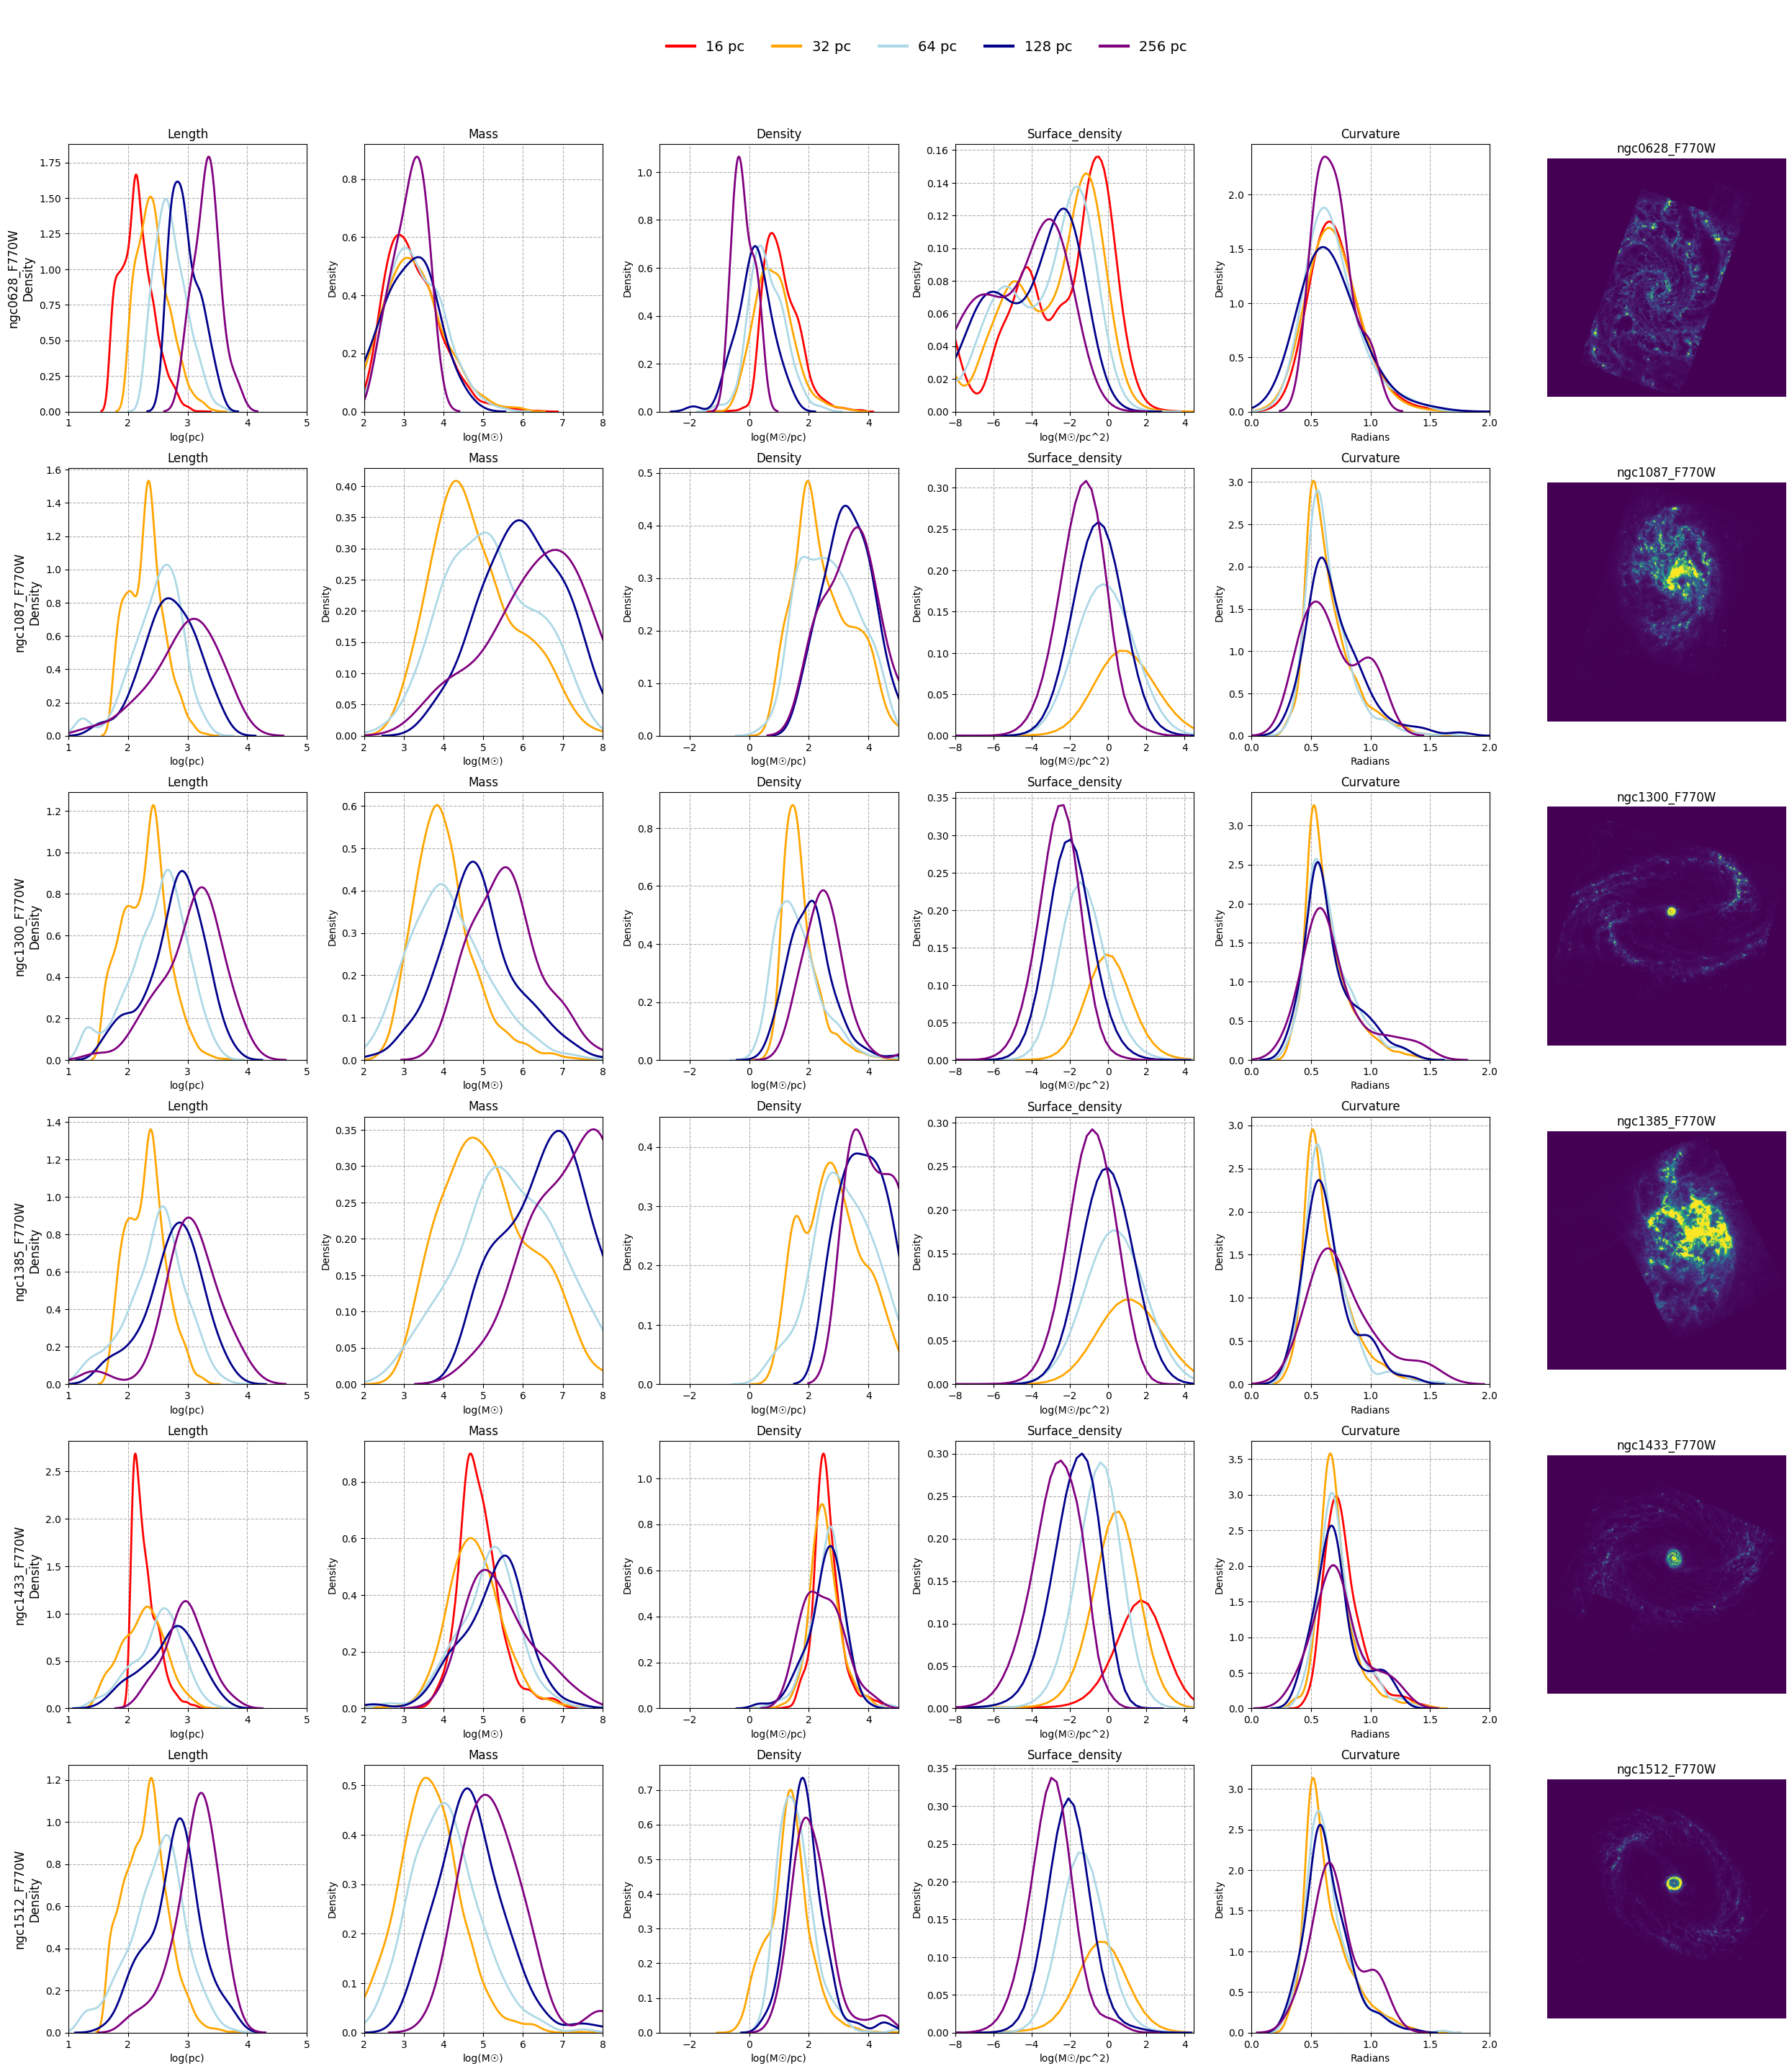

KeyboardInterrupt: 

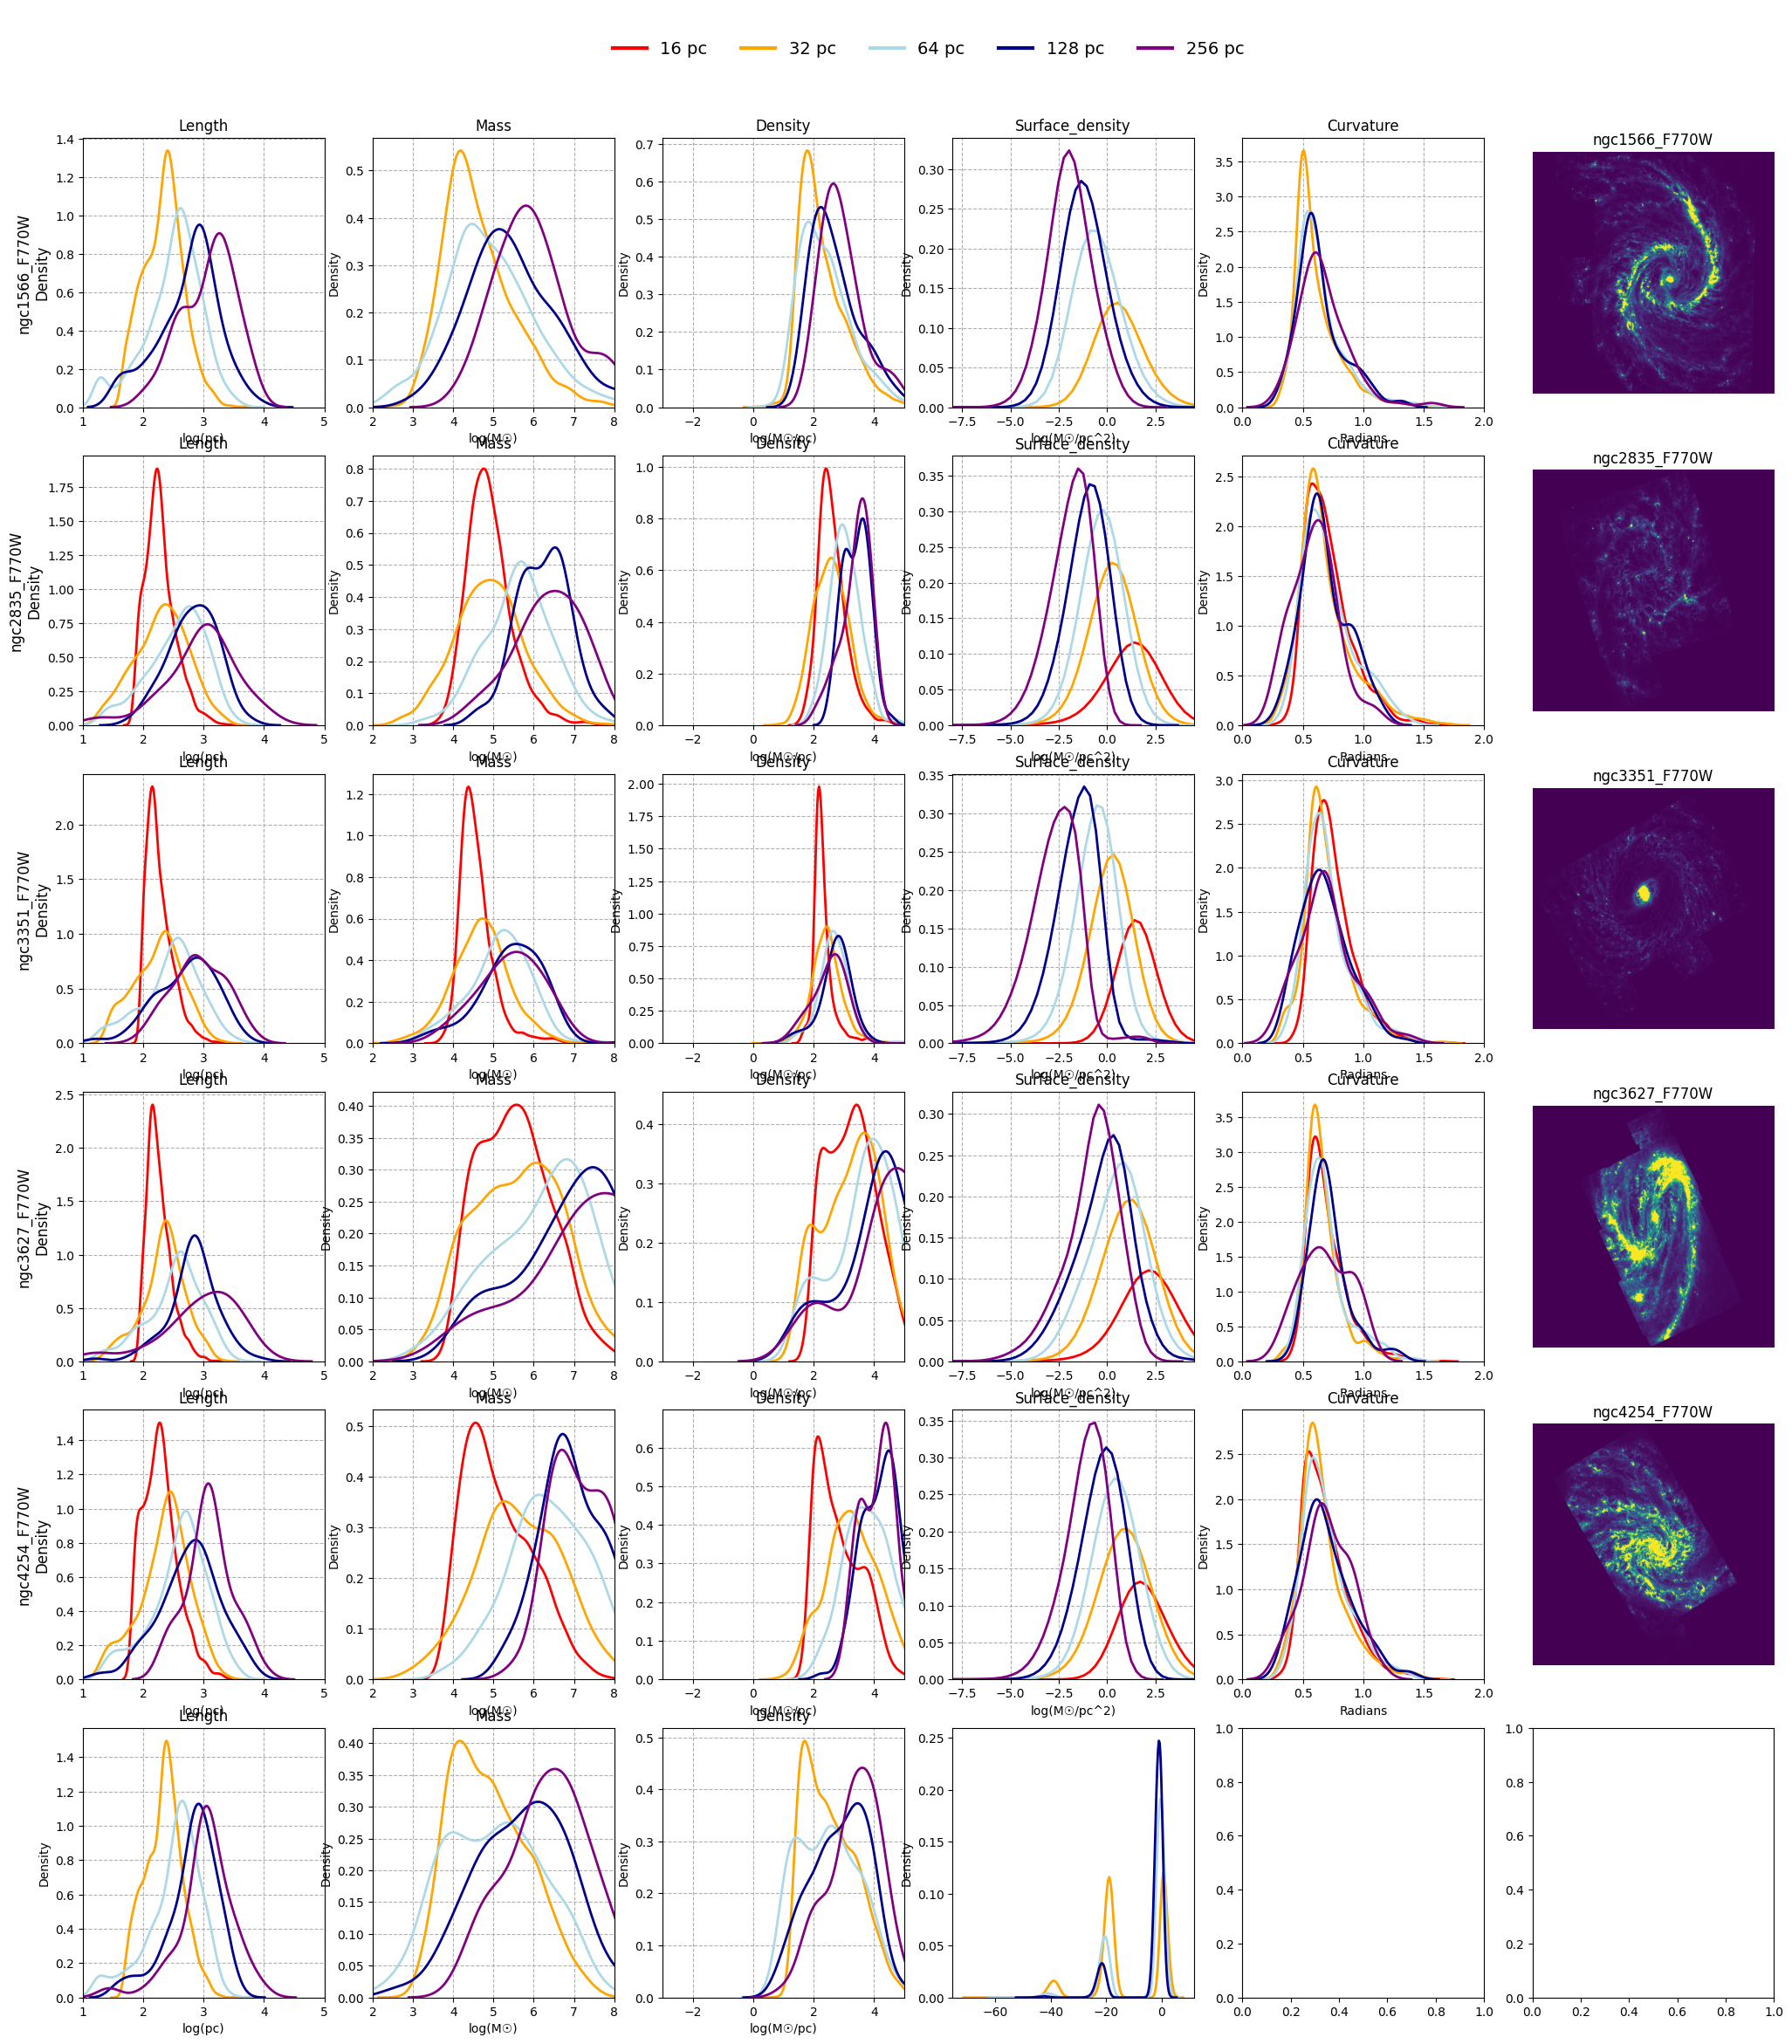

In [20]:
# Base paths
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
csv_path = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ImageData.xlsx")
fits_folder = base_dir / "OriginalImages"
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)
Num_Galaxies = 15
Galaxies_per_figure = 6

# Filter valid galaxy folders
galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder)
    and folder not in ['Figures', 'OriginalImages', 'masks_v5_simple', 'IC5146_PSW']
    and not folder.endswith('.txt') and not folder.endswith('.xlsx') and 'F770W' in folder]

valid_galaxies = []
galaxy_data = {}

for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'

    mass_dict = {}
    length_dict = {}
    density_dict = {}
    region_dict = {}
    curvature_dict = {}
    mass_surface = {}
    pixel_regions = []
    try:
        for file in os.listdir(synthetic_folder):
            if not file.endswith(".fits"):
                print(file)

                file_path = os.path.join(synthetic_folder, file)
                if file.endswith(".xlsx"):
                    df = pd.read_excel(file_path, engine='openpyxl')
                elif file.endswith(".xls"):
                    df = pd.read_excel(file_path)
                elif file.endswith(".csv"):
                    df = pd.read_csv(file_path)
                else:
                    continue

                scale = getScale(file_path)
                print(f'scale: {scale}')
                if scale is None:
                    continue

                try:
                    regions = df[f"Regions_{scale}.0"]
                    mass = df[f'Mass_{scale}.0']
                    Line_Density = df[f'Line_Density_{scale}.0'] #* (int(min_scale)/int(scale))
                    lengths = df[f'Length_{scale}.0'] #* (int(scale)/int(min_scale))
                    mass_dict[scale] = np.array(mass)
                    length_dict[scale] = np.array(lengths)
                    density_dict[scale] = np.array(Line_Density)
                    region_dict[scale] = np.array(regions)
                    curvature_col_name = f'Curvature_{scale}.0'

                    if curvature_col_name not in df.columns:
                        print(f"ERROR: Column '{curvature_col_name}' not found in dataframe!")
                        print(f"Available columns: {[col for col in df.columns if scale in col]}")
                        continue
                
                    curvature = df[curvature_col_name]
                    curvature_values = []

                    for i, s in enumerate(curvature):
                        if pd.isna(s):
                            continue
                        try:
                            if isinstance(s, (int, float, np.number)):
                                curvature_values.append(float(s))
                            elif isinstance(s, str):
                                numeric_part = s.split()[0]
                                curvature_values.append(float(numeric_part))
                            else:
                                print(f"Unexpected type at index {i}: {type(s)} - {s}")
                        except (ValueError, AttributeError) as e:
                            print(f"Error processing index {i}: {s} - {e}")
                            continue
                    

                    curvature_dict[scale] = np.array(curvature_values)

                except (KeyError, ValueError) as e:
                    print(f"Error: for {galaxy_name}", e)
                    continue

                try:
                    surface_density_path = base_dir / folder / 'Molecular_Mass'
                    # RegionData = np.array(getRegionData(folder, OrigData, OrigHeader))
                    distance_Mpc, _, pixscale, _, _, _, _, _ = getInfo(galaxy_name, csv_path)
                    ScalePix = pixscale * 4.848 * distance_Mpc
                    for fname in os.listdir(surface_density_path):
                        file = os.path.join(surface_density_path, fname)
                        if not file.lower().endswith(('.fits', '.fit', '.fz')) or not os.path.isfile(file):
                            continue
                        try:
                            scale = getScale(file)
                            assert(scale != None)

                            with fits.open(file, ignore_missing=True) as hdul:
                                if hdul[0].data is None:
                                    print(f"No data in primary HDU for {file}")
                                    continue
                                OrigData = np.array(hdul[0].data)
                                OrigHeader = hdul[0].header
                            bf = int(scale)/16
                            surface_density_data = np.array(OrigData.flatten()) / ((bf*ScalePix)**2)  #pixel mass/pixel area 

                            # filtered_regions = RegionData.flatten()[mask]  # Use the same boolean mask
                            # pixel_regions = filtered_regions
                            pixel_Regions = None
                            mass_surface[scale] = surface_density_data
                            print(f'molecular mass scale: {scale}')
                        except Exception as e:
                            print(f"Error: for {galaxy_name}", e)
                            continue

                except Exception as e:
                    print(f"Error: for {galaxy_name}", e)
                    continue

        if length_dict:
            valid_galaxies.append(galaxy_name)
            galaxy_data[galaxy_name] = {
                "mass": mass_dict,
                "length": length_dict,
                "density": density_dict,
                'region': region_dict,
                'curvature': curvature_dict,
                'surface_density': mass_surface,
                'pixel_regions' : pixel_regions
            }
    except Exception as e:
        print("Error:", e)
        

sr = False
plot_galaxies_subset(valid_galaxies[:Galaxies_per_figure], "First6Galaxies_Summary.png", fits_folder, galaxy_data, output_folder,sort_region = sr)
plot_galaxies_subset(valid_galaxies[Galaxies_per_figure:2*Galaxies_per_figure], "Middle6Galaxies_Summary.png",fits_folder, galaxy_data, output_folder, sort_region =sr)
plot_galaxies_subset(valid_galaxies[2*Galaxies_per_figure:], "Last6Galaxies_Summary.png",fits_folder, galaxy_data, output_folder, sort_region = sr)


KeyboardInterrupt: 

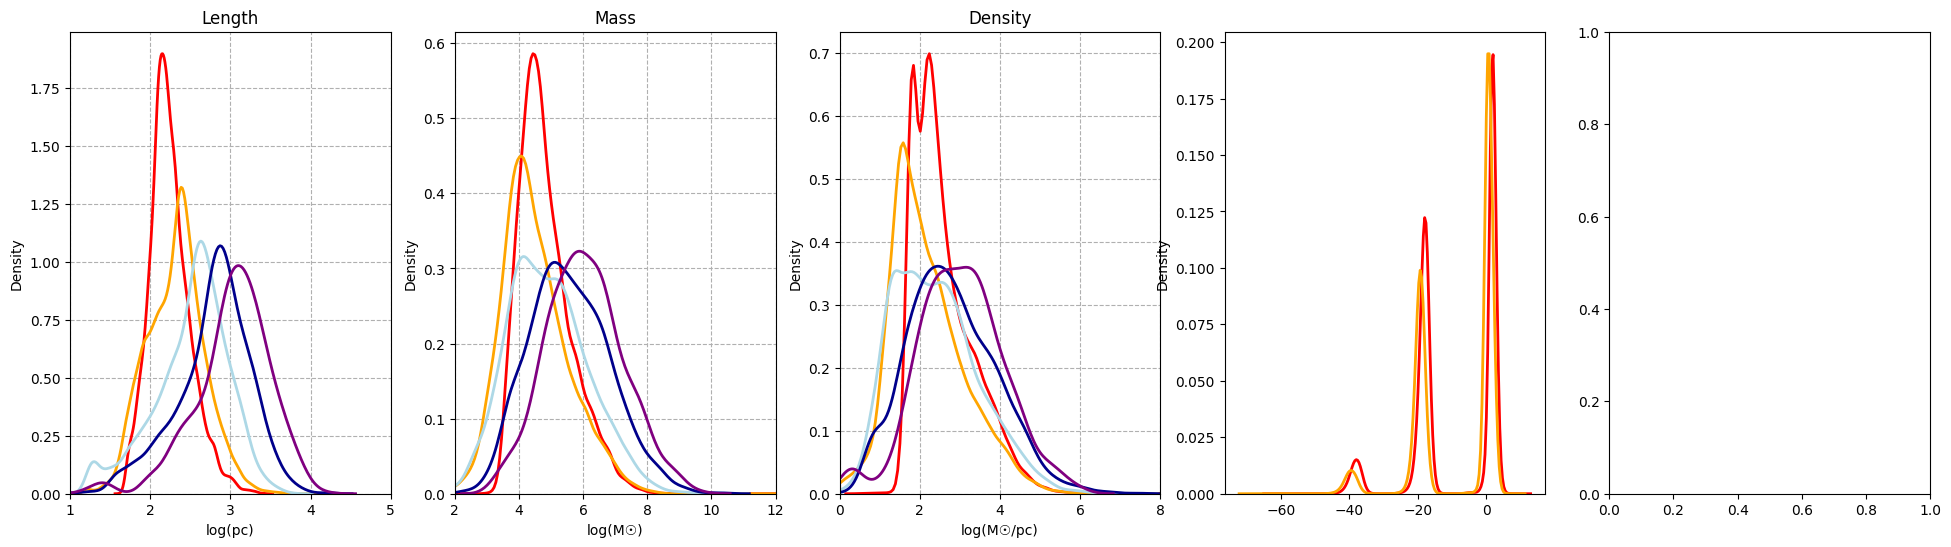

In [ ]:
# Combine data across all galaxies. TO FIX!
# Define the scales and initialize the master dict
scales = ['8', "16", "32", "64", "128", "256"]
quantities = ["mass", "length", "density", "surface_density", "curvature", "aspect"]
master_dict = {q: {scale: [] for scale in scales} for q in quantities}

# Combine data across all galaxies
for galaxy in valid_galaxies:
    mass_data = galaxy_data[galaxy]["mass"]
    length_data = galaxy_data[galaxy]["length"]
    density_data = galaxy_data[galaxy]["density"]
    curvature_data = galaxy_data[galaxy]["curvature"]
    surface_density_data = galaxy_data[galaxy]["surface_density"]
    for scale in scales:
        try:
            master_dict["mass"][scale].append(mass_data[scale])
            master_dict["length"][scale].append(length_data[scale])
            master_dict["density"][scale].append(density_data[scale])
            master_dict["curvature"][scale].append(curvature_data[scale])
            master_dict["surface_density"][scale].append(surface_density_data[scale])

        except KeyError:
            # Skip if this galaxy doesn't have data for this scale
            continue

# Convert lists of arrays into flat numpy arrays
for quantity in master_dict:
    for scale in master_dict[quantity]:
        if master_dict[quantity][scale]:  # Avoid empty lists
            master_dict[quantity][scale] = np.concatenate(master_dict[quantity][scale])
        else:
            master_dict[quantity][scale] = np.array([])  # fallback for missing data
fig, axes = plt.subplots(1, 5, figsize=(24, 6))

plot_quantity(master_dict["length"], "length", axes[0])
plot_quantity(master_dict["mass"], "mass", axes[1])
plot_quantity(master_dict["density"], "density", axes[2])
plot_quantity(master_dict["surface_density"], "surface_density", axes[3])
plot_quantity(master_dict["curvature"], "curvature", axes[4])  # <-- was axes[3]


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color, lw=3)
    for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
]
fig.legend(
    handles=legend_elements,
    labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=len(scale_colors), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Combined Distribution Across All Galaxies", fontsize=16)

# Save the plot
final_combined_path = output_folder / "AllGalaxies_Combined_Corrected.png"
fig.savefig(final_combined_path, dpi=300, bbox_inches='tight')
fig.savefig(final_combined_path.with_suffix(".pdf"), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
path  = r'c:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc1087_F770W\Molecular_Mass\ngc1087_F770W_JWST_Emission_starsub_CDDss0128pc.fits_MolecularMassMap_Grouped.fits'


def getRegionData(folder, OrigData, OrigHeader):
    """
    Find the appropriate region file and reproject into the size of the original image. 

    Parameters:
    - file (str): The original file path to match galaxy name
    - OrigData: Original data array
    - OrigHeader: Original header

    Returns:
    - data_new (float): region file reprojected into original image shape
    """

    # Look through files in region directory
    dir = r'C:\Users\jhoffm72\Documents\FilPHANGS\Data\masks_v5_simple'
    galaxy = folder.split("_")[0]  # Get galaxy name from file
    # Check if directory exists
    if not os.path.exists(dir):
        print(f"Region directory does not exist: {dir}")
        return np.full(OrigData.shape, np.nan)
    
    for region_file in os.listdir(dir):
        if galaxy.lower() in region_file.lower() and region_file.lower().endswith(('.fits', '.fit', '.fz')):
            fits_path = os.path.join(dir, region_file)
            
            try:
                with fits.open(fits_path, ignore_missing=True) as hdul:
                    data = np.array(hdul[0].data)  # region map
                    header = hdul[0].header

                data_new = reprojectWrapper(data, header, OrigHeader, OrigData)
                return data_new  # return region file reprojected into original file shape
                
            except Exception as e:
                print(f"Error processing region file {region_file}: {e}")
                continue
    
    print(f"No region file found for galaxy {galaxy} in {dir}")
    return np.full(OrigData.shape, np.nan)  # Return array of NaNs if no region file found

with fits.open(path, ignore_missing=True) as hdul:
    OrigData = np.array(hdul[0].data)
    OrigHeader = hdul[0].header
data = getRegionData('ngc1087', OrigData, OrigHeader)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


Set DATE-AVG to '2023-01-25T12:03:47.639' from MJD-AVG.
Set DATE-END to '2023-01-25T12:31:47.961' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.605143 from OBSGEO-[XYZ].
Set OBSGEO-H to 1660637438.040 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


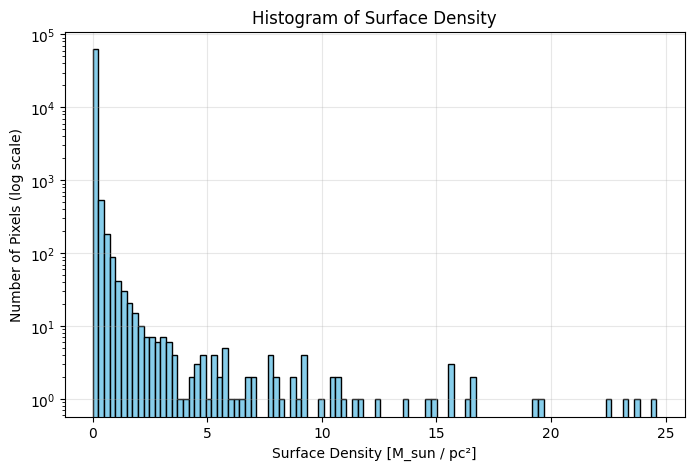

1594.5651351296408


In [ ]:
file = r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\Molecular_Mass\ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc.fits_MolecularMassMap_approximateFit.fits"
with fits.open(file, ignore_missing=True) as hdul:
    OrigData = np.array(hdul[0].data)
    OrigHeader = hdul[0].header
bf = 64/16
surface_density_data = np.array(OrigData.flatten()) / ((bf*ScalePix)**2)  #pixel mass/pixel area 
# Remove invalid values (NaNs, zeros, negatives)
surface_density_data = surface_density_data[np.isfinite(surface_density_data)]
surface_density_data = surface_density_data[surface_density_data > 0]  # only positive values

# --- Plot histogram ---
plt.figure(figsize=(8,5))
plt.hist((surface_density_data), bins=100, log=True, color='skyblue', edgecolor='black')
# plt.hist((surface_density_data), bins=100, log=True, color='skyblue', edgecolor='black')

plt.xlabel("Surface Density [M_sun / pc²]")
plt.ylabel("Number of Pixels (log scale)")
plt.title("Histogram of Surface Density")
plt.grid(True, alpha=0.3)
plt.show()
print((bf*ScalePix)**2)